# Titanic Data set
From Kaggle Titanic - ML from Disaster competition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans


from sklearn import metrics


Data dictionary

Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd


sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

# Import and characterize dataset

In [2]:
# import the training and testing data set

filename = 'train.csv'

train_df = pd.read_csv(filename)

filename2 = 'test.csv'

test_df = pd.read_csv(filename2)


In [3]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
train_df.shape

(891, 12)

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# What are the data types
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [13]:
# How many of each column are missing
# get names of columsn with missing values

cols_with_missing = [col for col in train_df.columns
                    if train_df[col].isnull().any()]

print('Columns with missing values: ', cols_with_missing)

for x in cols_with_missing:
    print(x, ':', train_df[x].isna().sum())

Columns with missing values:  ['Age', 'Cabin', 'Embarked']
Age : 177
Cabin : 687
Embarked : 2


# Explore basic percentages and visuallization of datset

In [7]:
# look at some simple percentages first

women = train_df.loc[train_df.Sex == 'female']['Survived']
rate_women = sum(women)/len(women)

print('% of women who survived:', rate_women)

% of women who survived: 0.7420382165605095


In [8]:
men = train_df.loc[train_df.Sex == 'male']['Survived']
rate_men = sum(men)/len(men)

print('% of men who survived:', rate_men)

% of men who survived: 0.18890814558058924


In [9]:
# check embarked location: C, Q, S

C_status = train_df.loc[train_df.Embarked == 'C']['Survived']
rate_C = sum(C_status)/len(C_status)

Q_status = train_df.loc[train_df.Embarked == 'Q']['Survived']
rate_Q = sum(Q_status)/len(Q_status)

S_status = train_df.loc[train_df.Embarked == 'S']['Survived']
rate_S = sum(S_status)/len(S_status)

print('% from C who survived:', rate_C)
print('% from Q who survived:', rate_Q)
print('% from S who survived:', rate_S)



% from C who survived: 0.5535714285714286
% from Q who survived: 0.38961038961038963
% from S who survived: 0.33695652173913043


In [10]:
# check P class: 1, 2, 3

status1 = train_df.loc[train_df.Pclass == 1]['Survived']
rate_1 = sum(status1)/len(status1)

    
status2 = train_df.loc[train_df.Pclass == 2]['Survived']
rate_2 = sum(status2)/len(status2)

status3 = train_df.loc[train_df.Pclass == 3]['Survived']
rate_3 = sum(status3)/len(status3)

print('% from 1 who survived:', rate_1)
print('% from 2 who survived:', rate_2)
print('% from 3 who survived:', rate_3)

% from 1 who survived: 0.6296296296296297
% from 2 who survived: 0.47282608695652173
% from 3 who survived: 0.24236252545824846


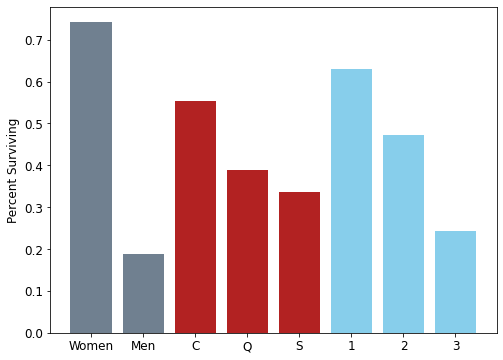

In [11]:
# Plot some percentages

labels = ['Women', 'Men', 'C', 'Q', 'S', '1', '2', '3']
percentages = [rate_women, rate_men, rate_C, rate_Q, rate_S, rate_1, rate_2, rate_3]
bar_color = ['slategray', 'slategray', 'firebrick', 'firebrick', 'firebrick', 'skyblue', 'skyblue', 'skyblue']

plt.figure(figsize=(8,6))
plt.bar(labels,percentages,color = bar_color)
plt.ylabel('Percent Surviving',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Break into training and validation data and run fandom forest classifier

In [15]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [16]:
# Break training data into testing and training sets so we can test a random forest classifier

# The columns we care about are Pclass[2], Sec[4], Age[5], SibSp[6], Parch[7], Fare[8], Embarked[10]

# target we are looking for is 'Survived'
y = train_df.Survived

####
# Age column is throwing nans, need to sort out why
# Column with missing data
# Age 177
# Cabin 687
# Embarked 2
####

# features = ['Pclass', 'Sex', 'SibSp', 'Age', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
# this is all of the features

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age']
#X = pd.get_dummies(train_df[features])
X = train_df[features]
#X_test = pd.get_dummies(test_df[features])


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, random_state = 1)


# Apply ordinal encoder to each column with categorical data
#object_cols = ['Sex', 'Embarked'] #select the categorical columns
#ordinal_encoder = OrdinalEncoder()
#label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
#label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

#apply one-hot encoder to each column with categorical data
object_cols = ['Sex', 'Embarked'] #select the categorical columns
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
oh_cols_train = pd.DataFrame(oh_encoder.fit_transform(X_train[object_cols]))
oh_cols_valid = pd.DataFrame(oh_encoder.transform(X_valid[object_cols]))

# one hot encoding removed the index, put it back
oh_cols_train.index = X_train.index
oh_cols_valid.index = X_valid.index

# remove categorical colums (will replace with oh encoding)
num_X_train = X_train.drop(object_cols, axis = 1)
num_X_valid = X_valid.drop(object_cols, axis = 1)

# add oh encoded columns to numerical features
oh_X_train = pd.concat([num_X_train, oh_cols_train], axis = 1)
oh_X_valid = pd.concat([num_X_valid, oh_cols_valid], axis = 1)


#Impute any missing values
# imputation
my_imputer = SimpleImputer(strategy='most_frequent')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(oh_X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(oh_X_valid))

# imputation removed column names; put them back
imputed_X_train.columns = oh_X_train.columns
imputed_X_valid.columns = oh_X_valid.columns



In [54]:
#print(X_train[X_train.isnull().any(axis=1)])
print(imputed_X_train.head())

   Pclass  SibSp  Parch     Fare   Age    0    1    2    3    4    5
0     3.0    2.0    0.0  23.2500  24.0  0.0  1.0  0.0  1.0  0.0  0.0
1     1.0    0.0    0.0  56.9292  30.0  1.0  0.0  1.0  0.0  0.0  0.0
2     2.0    0.0    0.0  10.5000  34.0  1.0  0.0  0.0  0.0  1.0  0.0
3     2.0    2.0    0.0  73.5000  21.0  0.0  1.0  0.0  0.0  1.0  0.0
4     2.0    0.0    0.0  10.5000  62.0  0.0  1.0  0.0  0.0  1.0  0.0


In [24]:
# Run a decision tree regressor
# Build the model

# define the model. 
titanic_model = DecisionTreeRegressor(random_state = 19)

# fit model
titanic_model.fit(imputed_X_train, y_train)

DecisionTreeRegressor(random_state=19)

In [55]:
# Run a random forest classifier

model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=1)
model.fit(imputed_X_train,y_train)
predictions = model.predict(imputed_X_valid)

In [56]:
# check these predictions
# have 891 rows for people on boat
# test size is 20 percent, or 178

print(metrics.accuracy_score(y_valid, predictions))

#print(metrics.classification_report(Y_validation, predictions))
print(metrics.confusion_matrix(y_valid , predictions))
print(metrics.f1_score(y_valid , predictions))


0.8044692737430168
[[96 10]
 [25 48]]
0.732824427480916


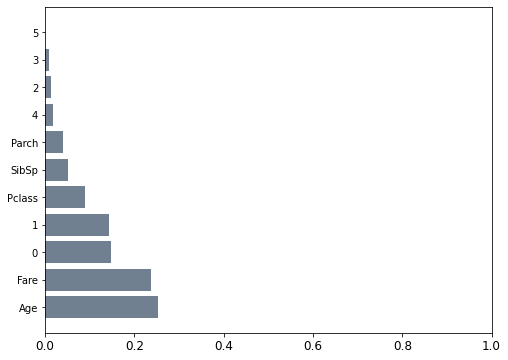

In [57]:
# visualize the importance of different features
feature_imp = pd.Series(model.feature_importances_,index=imputed_X_train.columns).sort_values(ascending=False)

#print(feature_imp[:])
#print(feature_imp.index.map(str))

plt.figure(figsize=(8,6))
plt.barh(feature_imp.index.map(str),feature_imp[:],color = 'slategray', align='center')
plt.xlim((0,1))
plt.xticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

In [ ]:
# set up a pipeline to run this automatically

In [10]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

In [11]:
# preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='most_frequent')

# preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [12]:
# define the model

model = RandomForestClassifier(n_estimators=350, max_depth=8, random_state=1)

In [18]:
# bundle preprocessing and moedling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', RandomForestClassifier())])

# preprocessing of training data, fit mode
my_pipeline.fit(X_train, y_train)

# preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)


print(metrics.accuracy_score(y_valid, preds))


0.776536312849162


In [86]:
# define a function so we can determine the best number of estimators
def get_score(n_estimators):
    
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', RandomForestClassifier(n_estimators= 350, max_depth= n_estimators,
                                                             random_state=1))])
    
    score = cross_val_score(my_pipeline, X_train, y_train,
                           cv = 3,
                           scoring= 'accuracy')
    
    return(score.mean())

In [91]:
results = {}
for i in range(1,12):
    results[i] = get_score(i)
    
# 350 is a good number of estimators
# 8 is a good max_depth

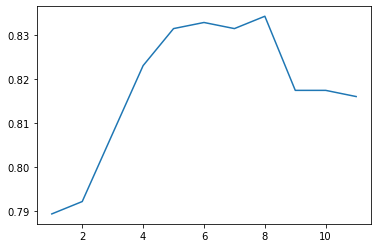

In [92]:
plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [56]:
# try using a grid search

# define the pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('rf', RandomForestClassifier())])

# define the parameters
parameters = {'rf__n_estimators':[50,100, 150, 200, 250, 300, 350, 400],
             'rf__max_depth':[3,6,9,12,15]}

grid_pipeline = GridSearchCV(my_pipeline, parameters,scoring='f1')
#print(grid_pipeline.get_params().keys())

grid_pipeline.fit(X_train, y_train)

print(grid_pipeline.best_params_)
#print(grid_pipeline.cv_results_)

{'rf__max_depth': 9, 'rf__n_estimators': 50}


In [57]:
grid_search_results = pd.DataFrame.from_dict(grid_pipeline.cv_results_)
grid_search_results.head()
#sns.heatmap(grid_search_results, annot = True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.051933,0.024868,0.005454,0.000570,3,50,"{'rf__max_depth': 3, 'rf__n_estimators': 50}",0.672897,0.688172,0.783505,0.838095,0.701031,0.736740,0.063513,39
1,0.073924,0.000550,0.007387,0.000086,3,100,"{'rf__max_depth': 3, 'rf__n_estimators': 100}",0.672897,0.702128,0.770833,0.803922,0.707071,0.731370,0.048344,40
2,0.109387,0.001419,0.009775,0.000282,3,150,"{'rf__max_depth': 3, 'rf__n_estimators': 150}",0.673077,0.723404,0.787879,0.815534,0.720000,0.743979,0.051133,34
3,0.143688,0.000786,0.012245,0.000216,3,200,"{'rf__max_depth': 3, 'rf__n_estimators': 200}",0.672897,0.723404,0.803922,0.826923,0.720000,0.749429,0.057228,33
4,0.174366,0.000671,0.013933,0.000182,3,250,"{'rf__max_depth': 3, 'rf__n_estimators': 250}",0.660377,0.695652,0.787879,0.834951,0.732673,0.742307,0.062677,35


<AxesSubplot:xlabel='param_rf__n_estimators', ylabel='param_rf__max_depth'>

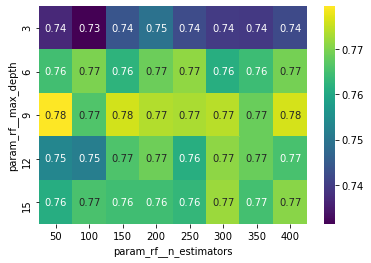

In [58]:
heatmap_data = pd.pivot_table(grid_search_results, values='mean_test_score',
                             index=['param_rf__max_depth'],
                             columns='param_rf__n_estimators')

sns.heatmap(heatmap_data, annot = True, cmap='viridis')

# K-means clustering

In [5]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
features = ['Pclass', 'SibSp', 'Fare']

# standardize
df_scaled = train_df.loc[:, features]
df_scaled = (df_scaled - df_scaled.mean(axis=0)) / df_scaled.std(axis=0)

kmeans = KMeans(n_clusters = 3,n_init=10, random_state=0)
train_df['cluster'] = kmeans.fit_predict(df_scaled)

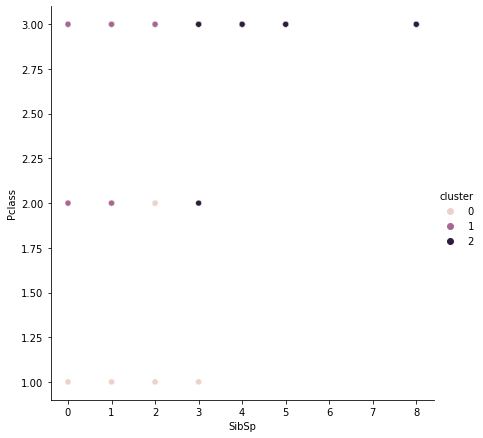

In [11]:
sns.relplot(x='SibSp', y = 'Pclass', hue='cluster', data=train_df, height = 6)

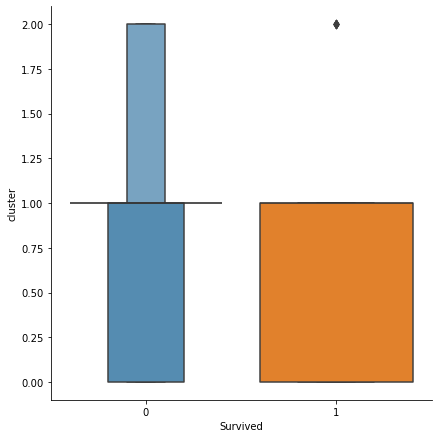

In [12]:
sns.catplot(x='Survived', y='cluster', data=train_df, kind='boxen', height=6)